In [1]:
#to link google drive to collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install bertopic
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 20.9 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [3]:
#request call was given using newyorktimes api with own key, https://api.nytimes.com/svc/archive/v1/2020/4.json?api-key=yourkey, /{year}/{month}.json,
#pulled all news articles from year 2020, April month. The json file was uploaded to google drive manually.
import json

with open('/content/drive/MyDrive/newyorktimes_articles_2020_April.json') as f:
    data = json.load(f)

type(data)

dict

In [4]:
#we'll be using "lead_paragraph" which contains the leading paragraph of each new story, printing out a few.
print(data["response"]["docs"][0]["lead_paragraph"])
print(" ")
print(data["response"]["docs"][1]["lead_paragraph"])
print(" ")
print(data["response"]["docs"][4000]["lead_paragraph"])

WASHINGTON — Two American airstrikes in Somalia in February killed two civilians and injured three more, the human rights group Amnesty International has alleged in a new report. The United States Africa Command has acknowledged those strikes happened, but said they killed only terrorists with the Qaeda-affiliated group Al Shabab.
 
The cars arrived at the food bank in southern Dallas in a stream — a minivan, a Chevrolet Tahoe, a sedan with a busted window, a Jaguar of unclear vintage. Inside the vehicles sat people who scarcely could believe they needed to be there.
 
WASHINGTON — President Trump arrives in the Oval Office these days as late as noon, when he is usually in a sour mood after his morning marathon of television.


In [5]:
#to extract all the "lead_paragraph" from our json file and storing them in an array, this array is then converted to a numpy array
import numpy as np

lead_paragraphs = []

for i in range(0, 5000):
    lead_paragraph = data["response"]["docs"][i]["lead_paragraph"]
    lead_paragraphs.append(lead_paragraph)

lead_paragraphs_array = np.array(lead_paragraphs)

In [6]:
#printing an element of the numpy array "lead_paragraphs_array" to see if data was written properly
lead_paragraphs_array[0]

'WASHINGTON — Two American airstrikes in Somalia in February killed two civilians and injured three more, the human rights group Amnesty International has alleged in a new report. The United States Africa Command has acknowledged those strikes happened, but said they killed only terrorists with the Qaeda-affiliated group Al Shabab.'

In [7]:
#converting our numpy array into a pandas dataframe
import pandas as pd

lead_paragraphs_df = pd.DataFrame(lead_paragraphs_array, columns=["LeadParagraph"])

In [8]:
#checking if data was written properly
lead_paragraphs_df.head(3)

,LeadParagraph
0,WASHINGTON — Two American airstrikes in Somali...
1,The cars arrived at the food bank in southern ...
2,Federal agents seized $29.6 million worth of i...


In [9]:
#checking if data was written properly
lead_paragraphs_df.shape

(5000, 1)

In [10]:
#START of data cleaning
#punctuations, symbols and unwanted character removal
import re

lead_paragraphs_df['LeadParagraph_processed_01'] = lead_paragraphs_df['LeadParagraph'].map(lambda line: re.sub('[,\.!?]', '', line))
lead_paragraphs_df.head(3)

,LeadParagraph,LeadParagraph_processed_01
0,WASHINGTON — Two American airstrikes in Somali...,WASHINGTON — Two American airstrikes in Somali...
1,The cars arrived at the food bank in southern ...,The cars arrived at the food bank in southern ...
2,Federal agents seized $29.6 million worth of i...,Federal agents seized $296 million worth of il...


In [11]:
#to convert everything to lowercase
lead_paragraphs_df['LeadParagraph_processed_02'] = lead_paragraphs_df['LeadParagraph_processed_01'].map(lambda line: line.lower())
lead_paragraphs_df.head(3)

,LeadParagraph,LeadParagraph_processed_01,LeadParagraph_processed_02
0,WASHINGTON — Two American airstrikes in Somali...,WASHINGTON — Two American airstrikes in Somali...,washington — two american airstrikes in somali...
1,The cars arrived at the food bank in southern ...,The cars arrived at the food bank in southern ...,the cars arrived at the food bank in southern ...
2,Federal agents seized $29.6 million worth of i...,Federal agents seized $296 million worth of il...,federal agents seized $296 million worth of il...


In [12]:
# Remove stopwords
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

stopwords = nltk.corpus.stopwords.words('english')
print(f'There are {len(stopwords)} default stopwords. They are {stopwords}')

stopwords.extend(['from', 'subject', 're', 'edu', 'use', 's']) #added an extended stopword list to remove further unwanted words
print(f'There are {len(stopwords)} default plus extended stopwords. They are {stopwords}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


There are 179 default stopwords. They are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'no

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
#stopword removal
lead_paragraphs_df['LeadParagraph_processed_03'] = lead_paragraphs_df['LeadParagraph_processed_02'].apply(lambda x: ' '.join([w for w in x.split() if w.lower() not in stopwords]))
lead_paragraphs_df.head(3)

,LeadParagraph,LeadParagraph_processed_01,LeadParagraph_processed_02,LeadParagraph_processed_03
0,WASHINGTON — Two American airstrikes in Somali...,WASHINGTON — Two American airstrikes in Somali...,washington — two american airstrikes in somali...,washington — two american airstrikes somalia f...
1,The cars arrived at the food bank in southern ...,The cars arrived at the food bank in southern ...,the cars arrived at the food bank in southern ...,cars arrived food bank southern dallas stream ...
2,Federal agents seized $29.6 million worth of i...,Federal agents seized $296 million worth of il...,federal agents seized $296 million worth of il...,federal agents seized $296 million worth illeg...


In [14]:
#lemmatization
lead_paragraphs_df['LeadParagraph_processed_04'] = lead_paragraphs_df['LeadParagraph_processed_03'].apply(lambda x: ' '.join([wn.lemmatize(w) for w in x.split() if w not in stopwords]))
lead_paragraphs_df.head(3)

,LeadParagraph,LeadParagraph_processed_01,LeadParagraph_processed_02,LeadParagraph_processed_03,LeadParagraph_processed_04
0,WASHINGTON — Two American airstrikes in Somali...,WASHINGTON — Two American airstrikes in Somali...,washington — two american airstrikes in somali...,washington — two american airstrikes somalia f...,washington — two american airstrikes somalia f...
1,The cars arrived at the food bank in southern ...,The cars arrived at the food bank in southern ...,the cars arrived at the food bank in southern ...,cars arrived food bank southern dallas stream ...,car arrived food bank southern dallas stream —...
2,Federal agents seized $29.6 million worth of i...,Federal agents seized $296 million worth of il...,federal agents seized $296 million worth of il...,federal agents seized $296 million worth illeg...,federal agent seized $296 million worth illega...


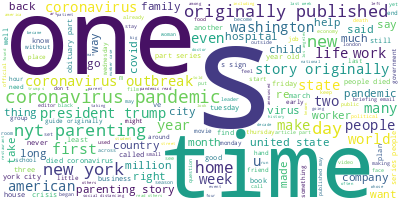

In [15]:
#to see if our data cleaning has been good, we will use wordcloud to do a quick visualization
from wordcloud import WordCloud

long_string = ','.join(list(lead_paragraphs_df['LeadParagraph_processed_04'].values))
#print(long_string)

wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

#END of data cleaning

In [16]:
#required configurations for bertopic model
from sklearn.cluster import KMeans
from umap import UMAP

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

kmeans_model = KMeans(n_clusters=10) #number of topic to be extracted

In [17]:
#fitting our data into bertopic model
from bertopic import BERTopic

#topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True,hdbscan_model=kmeans_model, n_gram_range=(1, 3))
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True,hdbscan_model=kmeans_model)
topics, probabilities = topic_model.fit_transform(lead_paragraphs_df['LeadParagraph_processed_04'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
# Get the list of topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,2282,0_coronavirus_pandemic_state_president,"[coronavirus, pandemic, state, president, new,...",[president trump daily coronavirus briefing wh...
1,1,1938,1_time_one_new_like,"[time, one, new, like, home, year, its, day, w...",[first time called serial dater roommate admit...
2,2,276,2_parenting_nyt_2019_originally,"[parenting, nyt, 2019, originally, published, ...",[story originally published may 6 2019 nyt par...
3,3,98,3_obituary_others_series_died,"[obituary, others, series, died, read, part, p...",[obituary part series people died coronavirus ...
4,4,91,4_via_subscribe_listen_podcasts,"[via, subscribe, listen, podcasts, podcast, mo...",[listen subscribe podcast mobile device:via ap...
5,5,83,5_county_extent_detailed_map,"[county, extent, detailed, map, table, number,...",[detailed county map show extent coronavirus o...
6,6,79,6_signup_email_heres_briefing,"[signup, email, heres, briefing, want, get, ph...","[(want get briefing email here’s sign-up), (wa..."
7,7,67,7_editor_submission_thank_updated,"[editor, submission, thank, updated, selection...","[editor:, editor:, editor:]"
8,8,46,8_leonhardts_today_email_signup,"[leonhardts, today, email, signup, david, week...",[article part david leonhardt’s newsletter sig...
9,9,40,9____,"[, , , , , , , , , ]","[, , ]"


In [19]:
# Get top 10 terms for a topic
topic_model.get_topic(0)

[('coronavirus', 0.045299649408515275),
 ('pandemic', 0.02363971273988135),
 ('state', 0.02078999560213568),
 ('president', 0.020669627735799268),
 ('new', 0.019477077950087508),
 ('washington', 0.018047115984203308),
 ('trump', 0.017532869170967528),
 ('people', 0.01655410552511456),
 ('week', 0.014806737998977278),
 ('health', 0.014229942810597956)]

In [20]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=12)

In [21]:
# Visualize intertopic distance
topic_model.visualize_topics()

In [22]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=10)

In [23]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

In [24]:
#END ~Written and Compiled by Akash Siva Kumar

In [25]:
#reference
#https://github.com/Ali-Alameer/NLP/blob/main/week10_topic_modelling_bertopic.ipynb
#How to use BERTopic - Machine Learning Assisted Topic Modeling in Python, https://www.youtube.com/watch?v=v3SePt3fr9g